In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import nglview as nv
import protein
from protein.model_analysis import get_predicted_transformations, pca_latent_space, mask_evolution, plot_loss
from protein.main import rotate_residues, rotate_domain_pdb_structure_matrix, translate_residues, translate_domain_pdb_structure
from pytorch3d.transforms import matrix_to_axis_angle, axis_angle_to_matrix
from Bio.PDB import PDBParser
from Bio.PDB import PDBIO
from sklearn.decomposition import PCA
from pytorch3d.transforms import matrix_to_axis_angle, axis_angle_to_matrix, quaternion_to_axis_angle

In [781]:
def sample_structure(latent_variables, model):
    batch_size = latent_variables.shape[0]
    model.batch_size = batch_size
    weights = model.compute_mask()
    output = model.decoder.forward(latent_variables)
    output = torch.reshape(output, (batch_size, model.N_domains,2*3))
    scalars_per_domain = output[:, :, :3]
    ones = torch.ones(size=(batch_size, model.N_domains, 1), device="cpu")
    quaternions_per_domain = torch.cat([ones,output[:, :, 3:]], dim=-1)
    rotations_per_residue = model.compute_rotations(quaternions_per_domain, weights)
    new_structure, translations = model.deform_structure(weights, scalars_per_domain, rotations_per_residue)
    return translations, rotations_per_residue, quaternion_to_axis_angle(quaternions_per_domain)

def matrix_to_axis_angles(rotation_matrices):
    axis_angle = matrix_to_axis_angle(rotation_matrices)
    angle = torch.sqrt(torch.sum(axis_angle**2, dim=-1))
    axis = axis_angle/angle[:, :, None]
    return angle.detach().numpy(), axis.detach().numpy()

def get_axis_and_angle(axis_angle):
    angle = torch.sqrt(torch.sum(axis_angle**2, dim=-1))
    axis = axis_angle/angle[:, :, None]
    return angle.detach().numpy(), axis.detach().numpy()

## I. A bit of context

The images are 64x64 pixels. For a pixel size of roughly 4.7 Å.

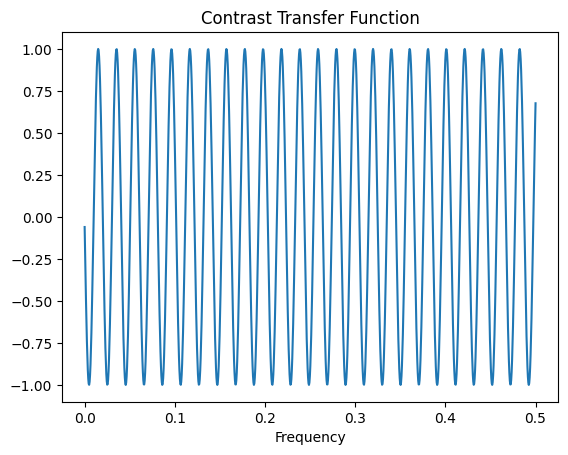

In [799]:
ctf = np.load("data/ctf.npy")
freq = np.linspace(0, 0.5, 1000)
plt.plot(freq, ctf)
plt.title("Contrast Transfer Function")
plt.xlabel("Frequency")
plt.show()

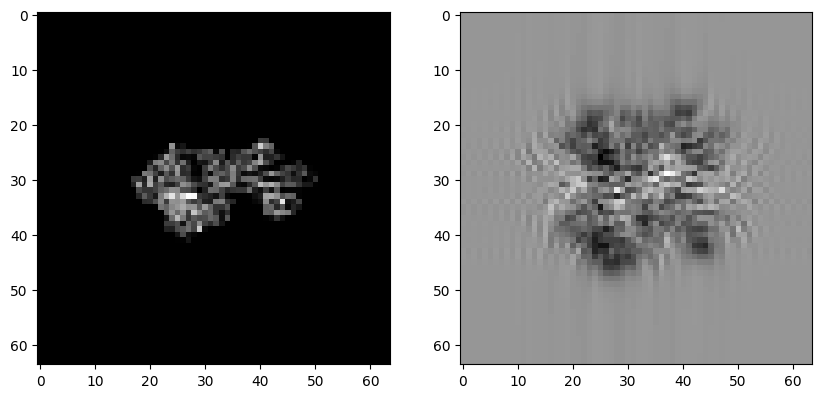

In [800]:
ctf_image = np.load("data/ctf_corrupted.npy")
no_ctf_image = np.load("data/no_ctf_corrupted.npy")
fig, axs = plt.subplots(1,2, figsize=(10, 10))
axs[0].imshow(no_ctf_image, cmap="gray")
axs[1].imshow(ctf_image, cmap="gray")
plt.show()


## II. Continuous distribution

### A. Training set

In [14]:
path = "data/vaeContinuous/"

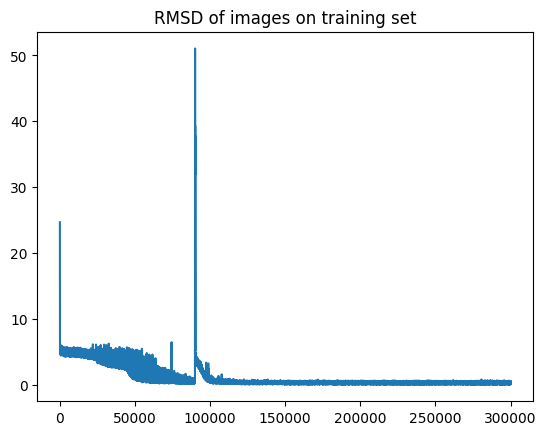

In [16]:
rmsd = np.load(path + "losses_rmsd.npy")
plt.plot(rmsd)
plt.title("RMSD of images on training set")
plt.show()

In [11]:
mask_evol = mask_evolution("data/vaeContinuous/masks/")

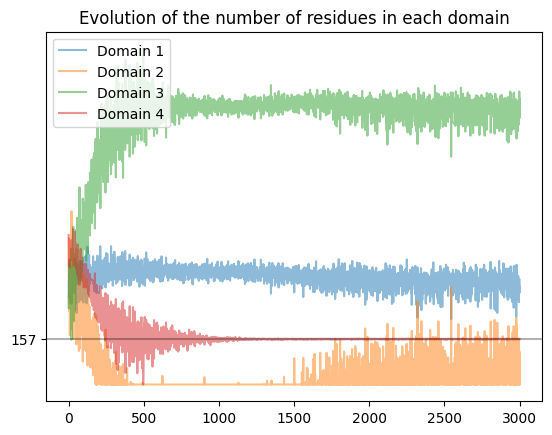

In [17]:
plt.plot(mask_evol[:, 0], label="Domain 1", alpha=0.5)
plt.plot(mask_evol[:, 1], label="Domain 2", alpha=0.5)
plt.plot(mask_evol[:, 2], label="Domain 3", alpha=0.5)
plt.plot(mask_evol[:, 3], label="Domain 4", alpha=0.5)
plt.axhline(y=157, alpha=0.3, color="black")
plt.yticks([157])
plt.legend(loc="upper left")
plt.title("Evolution of the number of residues in each domain")
plt.show()

In [628]:
latent_distrib = np.load("data/vaeContinuous/latent_distrib.npy")
indexes = np.load("data/vaeContinuous/indexes.npy")
all_latent_distrib = np.concatenate(latent_distrib, axis= 0)
all_indexes = np.concatenate(indexes, axis= 0)

In [505]:
model = torch.load("data/vaeContinuous/full_model", map_location=torch.device('cpu'))
model.batch_size = 10000
model.device = "cpu"

In [508]:
translations_training, rotations_per_residue_training, axis_angle_domain_training = sample_structure(torch.tensor(all_latent_distrib[:, :1])
                                                                                                     , model)

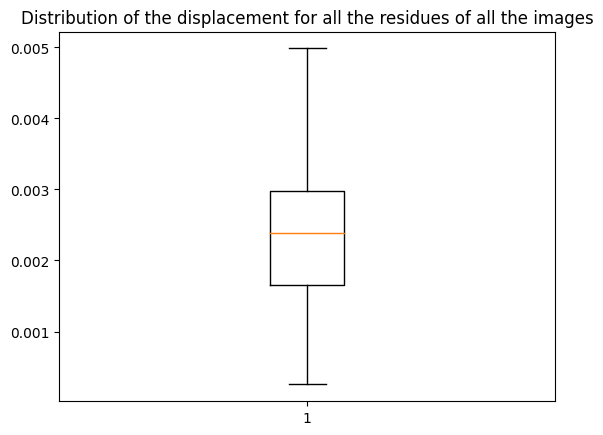

In [520]:
translations_magnitude_training = torch.sqrt(torch.sum(translations_training**2, dim=-1))
plt.boxplot(translations_magnitude_training.flatten().detach().numpy(), showfliers=False)
plt.title("Distribution of the displacement for all the residues of all the images")
plt.show()

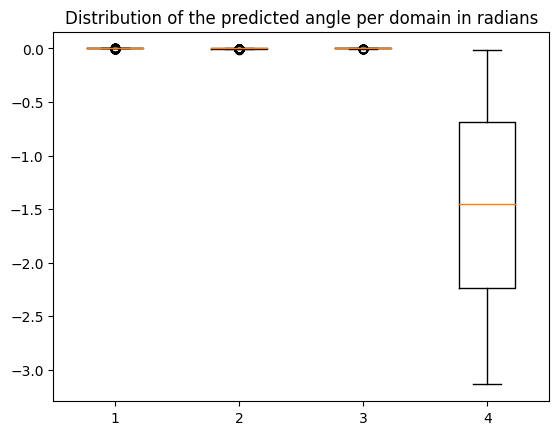

In [538]:
angle_training, axis_training = get_axis_and_angle(axis_angle_domain_training)
angle_training *= -1
axis_training *= -1
plt.boxplot(angle_training[:, :], showfliers=True)
plt.title("Distribution of the predicted angle per domain in radians")
plt.show()

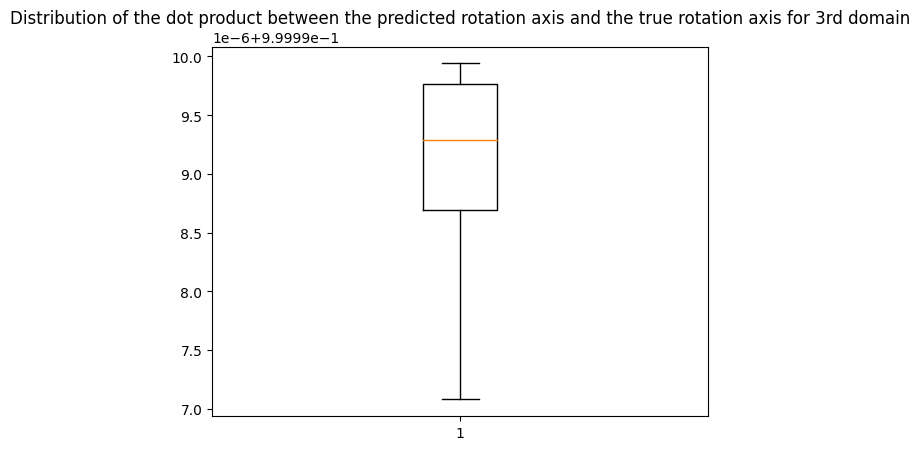

In [547]:
dot_prod = np.matmul(axis_training[:, 3, :], np.array([0.0, 1.0, 0.0]))
plt.boxplot(dot_prod, showfliers=False)
plt.title("Distribution of the dot product between the predicted rotation axis and the true rotation axis for 3rd domain")
plt.show()

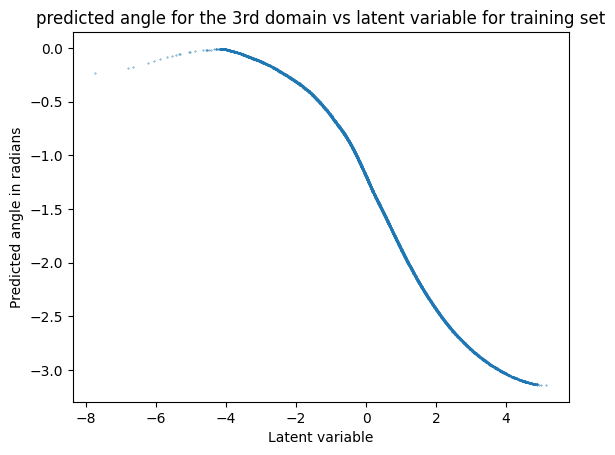

Correlation: [[ 1.         -0.97892201]
 [-0.97892201  1.        ]]


In [559]:
plt.scatter(all_latent_distrib[:, 0], angle_training[:, 3], s=0.1)
plt.xlabel("Latent variable")
plt.ylabel("Predicted angle in radians")
plt.title("predicted angle for the 3rd domain vs latent variable for training set")
plt.show()
print("Correlation:", np.corrcoef(all_latent_distrib[:, 0], angle_training[:, 3]))

In [608]:
true_rot_mat_training = torch.load(path + "training_conformation_rotation_matrices.npy", 
                          map_location=torch.device('cpu'))
true_axis_angle_training = matrix_to_axis_angle(true_rot_mat_training)
true_angles_training = torch.sqrt(torch.sum(true_axis_angle_training[:, 2, :]**2, dim=-1))
true_axis_training = true_axis_angle_training[:, 3]/true_angles_training[:, None]
true_angles_training *= -1

In [610]:
#First we set the angle to the range [-pi, pi] and then we minus the angle because we change the axis
#from [0, -1, 0] to [0, 1, 0]
true_angles_training[true_angles_training < -np.pi] = -(true_angles_training[true_angles_training < -np.pi] + 2*np.pi)

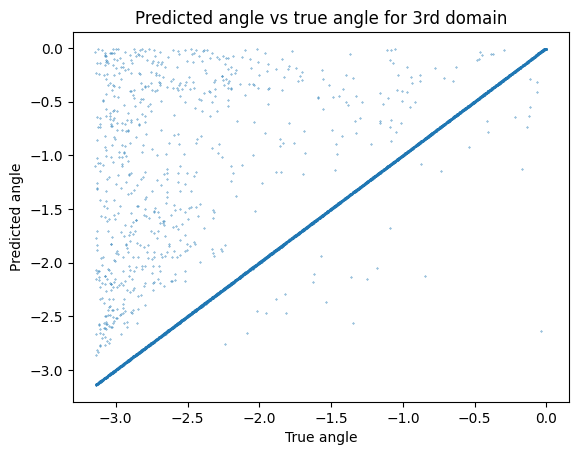

Correlation: [[1.         0.88786566]
 [0.88786566 1.        ]]


In [614]:
plt.scatter(true_angles_training, angle_training[:, 3], s=0.1)
plt.xlabel("True angle")
plt.ylabel("Predicted angle")
plt.title("Predicted angle vs true angle for 3rd domain")
plt.show()
print("Correlation:", np.corrcoef(true_angles_training, angle_training[:, 3]))

In [615]:
#pdb_parser = PDBParser()
#io = PDBIO()
#for i in range(10000):
#    if i%100 == 0:
#        print(i)
#        
#    struct = pdb_parser.get_structure("A", "data/vaeContinuous/ranked_0.pdb")
#    protein.main.rotate_domain_pdb_structure_matrix(struct, 1353, 1510, true_rot_mat[i, 2, :, :], local_frame_in_columns)
#    io.set_structure(struct)
#    io.save("data/vaeContinuous/true_structures/true_structure"+str(i)+".pdb", preserve_atom_numbering = True)

In [616]:
#pdb_parser = PDBParser()
#io = PDBIO()
#for i in range(0, 10000):
#    if i%100 == 0:
#        print(i)
        
#    struct = pdb_parser.get_structure("A", "data/vaeContinuous/ranked_0.pdb")
#    protein.main.rotate_residues(struct, rotations_per_residue_np[i], local_frame_in_columns)
#    io.set_structure(struct)
#    io.save("data/vaeContinuous/predicted_structures/predicted"+str(i)+".pdb", preserve_atom_numbering = True)
    

In [617]:
#all_rmsd = {}
#for i in range(10000):
#    true = "data/vaeContinuous/true_structures/true_structure"+str(i)+".pdb"
#    predicted = "data/vaeContinuous/predicted_structures/predicted"+str(i)+".pdb"
#    rmsd = protein.main.compute_rmsd_pdb(true, predicted)
#    print(i, rmsd)
#    all_rmsd["predicted"+str(i)+".pdb"] = rmsd

In [618]:
#with open("data/vaeContinuous/predicted_structures/rmsd.txt", "w") as f:
#    for i, tup in enumerate(sorted_rmsd):
#        print(i)
#        f.write(f"{tup[0]}\t {tup[1]}\n")

### B. Test set

In [629]:
latent_distrib_test = np.load("data/vaeContinuous/test_run/latent_distrib.npy")
indexes = np.load("data/vaeContinuous/test_run/indexes.npy")
all_latent_distrib_test = np.concatenate(latent_distrib_test, axis= 0)
all_indexes = np.concatenate(indexes, axis= 0)

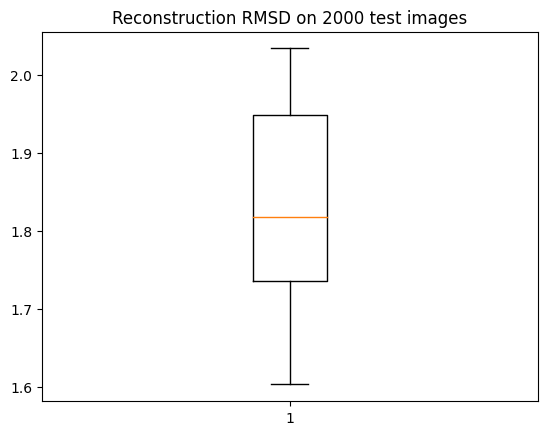

In [630]:
test_rmsd = np.load("data/vaeContinuous/test_run/losses_rmsd.npy")
plt.boxplot(test_rmsd)
plt.title("Reconstruction RMSD on 2000 test images")
plt.show()

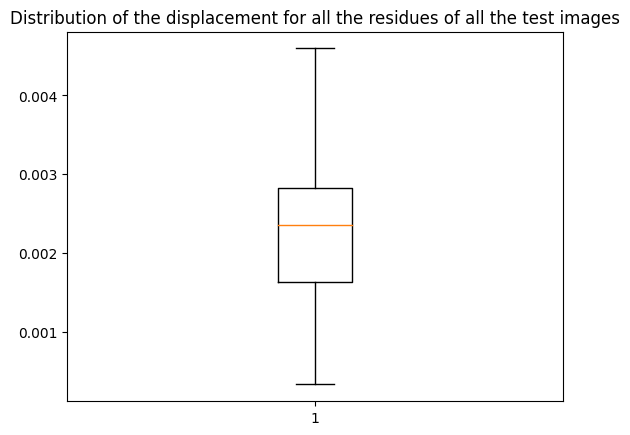

In [624]:
translations_magnitude_test = torch.sqrt(torch.sum(translations_test**2, dim=-1))
plt.boxplot(translations_magnitude_test.flatten().detach().numpy(), showfliers=False)
plt.title("Distribution of the displacement for all the residues of all the test images")
plt.show()

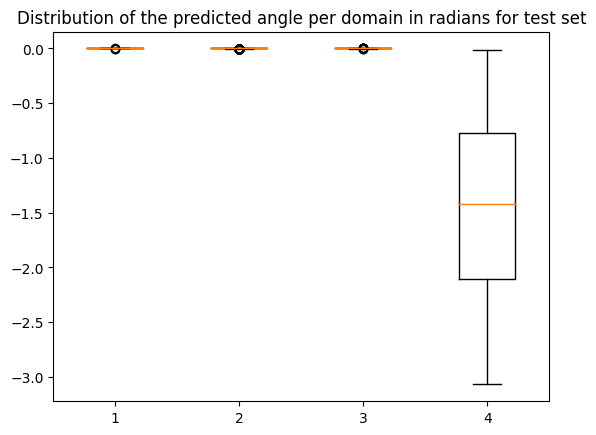

In [625]:
angle_test, axis_test = get_axis_and_angle(axis_angle_domain_test)
angle_test *= -1
axis_test *= -1
plt.boxplot(angle_test[:, :], showfliers=True)
plt.title("Distribution of the predicted angle per domain in radians for test set")
plt.show()

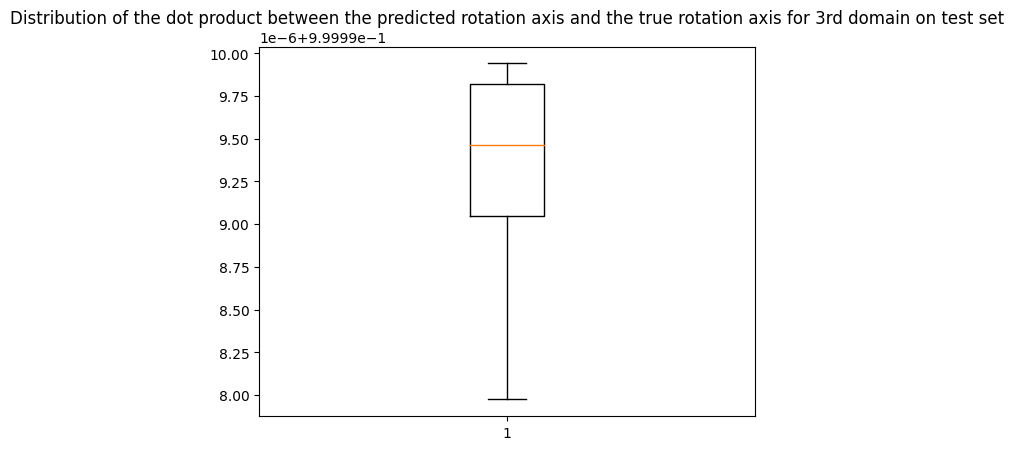

In [626]:
dot_prod_test = np.matmul(axis_test[:, 3, :], np.array([0.0, 1.0, 0.0]))
plt.boxplot(dot_prod_test, showfliers=False)
plt.title("Distribution of the dot product between the predicted rotation axis and the true rotation axis for 3rd domain on test set")
plt.show()

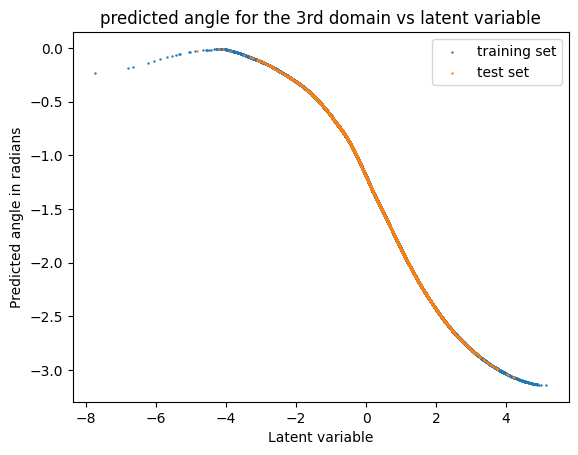

Correlation: [[ 1.         -0.98747948]
 [-0.98747948  1.        ]]


In [641]:
plt.scatter(all_latent_distrib[:, 0], angle_training[:, 3], s=0.5, label="training set")
plt.scatter(all_latent_distrib_test[:, 0], angle_test[:, 3], s=0.5, label="test set")
plt.xlabel("Latent variable")
plt.ylabel("Predicted angle in radians")
plt.title("predicted angle for the 3rd domain vs latent variable")
plt.legend(loc="upper right")
plt.show()
print("Correlation:", np.corrcoef(all_latent_distrib_test[:, 0], angle_test[:, 3]))

In [643]:
true_rot_mat_test = torch.load("data/vaeContinuous/test_run/test_conformation_rotation_matrices.npy", 
                          map_location=torch.device('cpu'))
true_axis_angle_test = matrix_to_axis_angle(true_rot_mat_test)
true_angles_test = torch.sqrt(torch.sum(true_axis_angle_test[:, 2, :]**2, dim=-1))
true_axis_test = true_axis_angle_test[:, 3]/true_angles_test[:, None]
true_angles_test *= -1

In [644]:
#First we set the angle to the range [-pi, pi] and then we minus the angle because we change the axis
#from [0, -1, 0] to [0, 1, 0]
true_angles_test[true_angles_test < -np.pi] = -(true_angles_test[true_angles_test < -np.pi] + 2*np.pi)

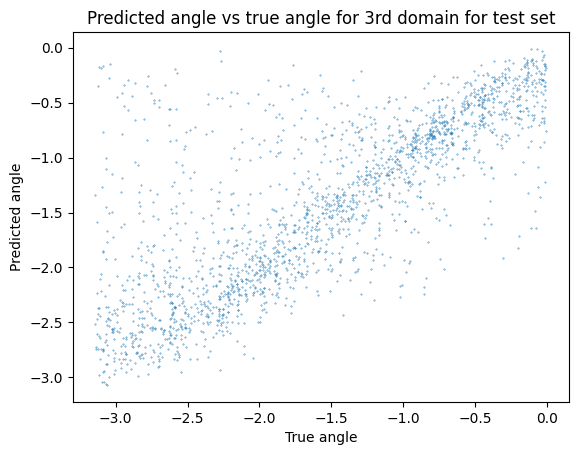

Correlation: [[1.         0.77576544]
 [0.77576544 1.        ]]


In [645]:
plt.scatter(true_angles_test, angle_test[:, 3], s=0.1)
plt.xlabel("True angle")
plt.ylabel("Predicted angle")
plt.title("Predicted angle vs true angle for 3rd domain for test set")
plt.show()
print("Correlation:", np.corrcoef(true_angles_test, angle_test[:, 3]))

In [646]:
#pdb_parser = PDBParser()
#io = PDBIO()
#for i in range(0, 2000):
#    if i%100 == 0:
#        print(i)
        
#    struct = pdb_parser.get_structure("A", "data/vaeContinuous/ranked_0.pdb")
#    protein.main.rotate_residues(struct, rotations_per_residue_np[i], local_frame_in_columns)
#    io.set_structure(struct)
#    io.save("data/vaeContinuous/test_run/predicted_structures/predicted"+str(i)+".pdb", preserve_atom_numbering = True)
    

In [647]:
#pdb_parser = PDBParser()
#io = PDBIO()
#for i in range(2000):
#    if i%100 == 0:
#        print(i)
        
#    struct = pdb_parser.get_structure("A", "data/vaeContinuous/ranked_0.pdb")
#    protein.main.rotate_domain_pdb_structure_matrix(struct, 1353, 1510, true_rot_mat[i, 2, :, :], local_frame_in_columns)
#    io.set_structure(struct)
#    io.save("data/vaeContinuous/test_run/true_structures/true_structure"+str(i)+".pdb", preserve_atom_numbering = True)

In [648]:
#all_rmsd = {}
#for i in range(2000):
#    true = "data/vaeContinuous/test_run/true_structures/true_structure"+str(i)+".pdb"
#    predicted = "data/vaeContinuous/test_run/predicted_structures/predicted"+str(i)+".pdb"
#    rmsd = protein.main.compute_rmsd_pdb(true, predicted)
#    print(i, rmsd)
#    all_rmsd["predicted"+str(i)+".pdb"] = rmsd

In [649]:
#sorted_rmsd = sorted(list(all_rmsd.items()), key = lambda x: x[1])

In [650]:
#with open("data/vaeContinuous/test_run/predicted_structures/rmsd.txt", "w") as f:
#    for i, tup in enumerate(sorted_rmsd):
#        print(i)
#        f.write(f"{tup[0]}\t {tup[1]}\n")

In [457]:
interpol_latent = torch.tensor(np.linspace(-4, 4, 10), dtype=torch.float32)[:, None]
translations_interpol, rotation_per_residues_interpol, axis_angle_domain_interpol = sample_structure(interpol_latent, model)
angle, axis = matrix_to_axis_angles(torch.tensor(rotation_per_residues_interpol))

/var/folders/6m/46qftl4j0kjcyvy_lh05f3_w00ztgk/T/ipykernel_78705/2264170786.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  angle, axis = matrix_to_axis_angles(torch.tensor(rotation_per_residues_interpol))


In [501]:
pdb_parser = PDBParser()
io = PDBIO()
for i in range(0, 10):        
    struct = pdb_parser.get_structure("A", "data/vaeContinuous/ranked_0.pdb")
    protein.main.rotate_residues(struct, rotation_per_residues_interpol[i].detach().numpy(), local_frame_in_columns)
    io.set_structure(struct)
    io.save("data/vaeContinuous/test_run/interpolation/predicted"+str(i)+".pdb", preserve_atom_numbering = True)
    

## II. 2 conformations

### A. Training set

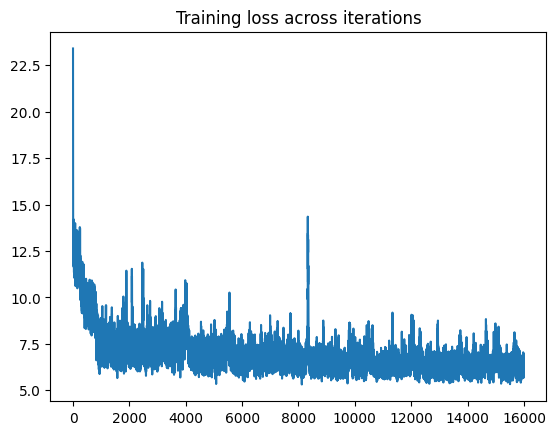

In [57]:
rmsd = np.load("data/vae2Conformations/losses_rmsd.npy")
plt.plot(rmsd[:16000])
plt.title("Training loss across iterations")
plt.show()

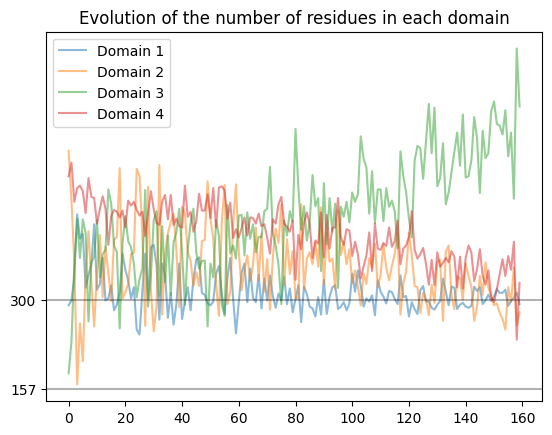

In [56]:
mask_evol = mask_evolution("data/vae2Conformations/masks/")
plt.plot(mask_evol[:160, 0], label="Domain 1", alpha=0.5)
plt.plot(mask_evol[:160, 1], label="Domain 2", alpha=0.5)
plt.plot(mask_evol[:160, 2], label="Domain 3", alpha=0.5)
plt.plot(mask_evol[:160, 3], label="Domain 4", alpha=0.5)
plt.axhline(y=157, alpha=0.3, color="black")
plt.axhline(y=300, alpha=0.3, color="black")
plt.yticks([157, 300])
plt.legend(loc="upper left")
plt.title("Evolution of the number of residues in each domain")
plt.show()

In [655]:
latent_distrib = np.load("data/vae2Conformations/latent_distrib.npy")
indexes = np.load("data/vae2Conformations/indexes.npy")
all_latent_distrib = np.concatenate(latent_distrib, axis= 0)
all_indexes = np.concatenate(indexes, axis= 0)
pca = PCA()
pca_latent = pca.fit_transform(all_latent_distrib[:, :9])
cols = ["blue" if i < 5000 else "red" for i in all_indexes]

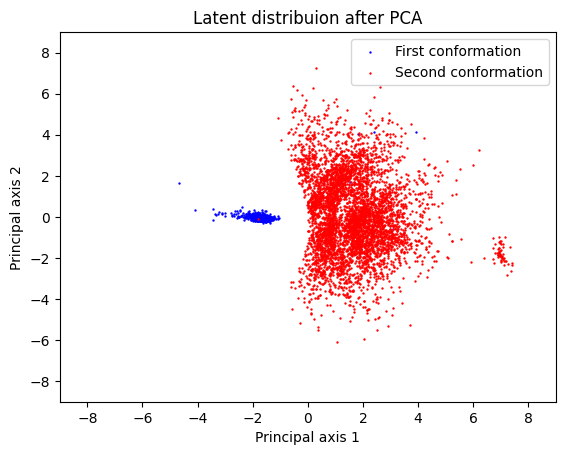

In [663]:
plt.scatter(pca_latent[:5000, 0], pca_latent[:5000, 1], s=0.5, color="blue", label="First conformation")
plt.scatter(pca_latent[5000:, 0], pca_latent[5000:, 1], s=0.5, color="red", label="Second conformation")
plt.xlim([-9, 9])
plt.ylim([-9, 9])
plt.xlabel("Principal axis 1")
plt.ylabel("Principal axis 2")
plt.legend(loc="upper right")
plt.title("Latent distribuion after PCA")
plt.show()

In [664]:
model = torch.load("data/vae2Conformations/full_model", map_location=torch.device('cpu'))
model.device = "cpu"

In [698]:
translations_training, rotations_per_residue_training, axis_angle_per_domain_training = sample_structure(
    torch.tensor(all_latent_distrib[:, :9], dtype=torch.float32), model)

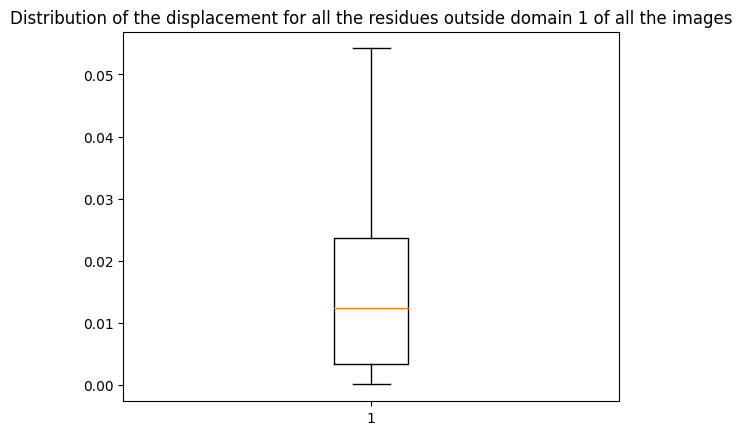

In [757]:
translations_magnitude_training = torch.sqrt(torch.sum(translations_training**2, dim=-1))
plt.boxplot(translations_magnitude_training[:, 300:].flatten().detach().numpy(), showfliers=False)
plt.title("Distribution of the displacement for all the residues outside domain 1 of all the images")
plt.show()

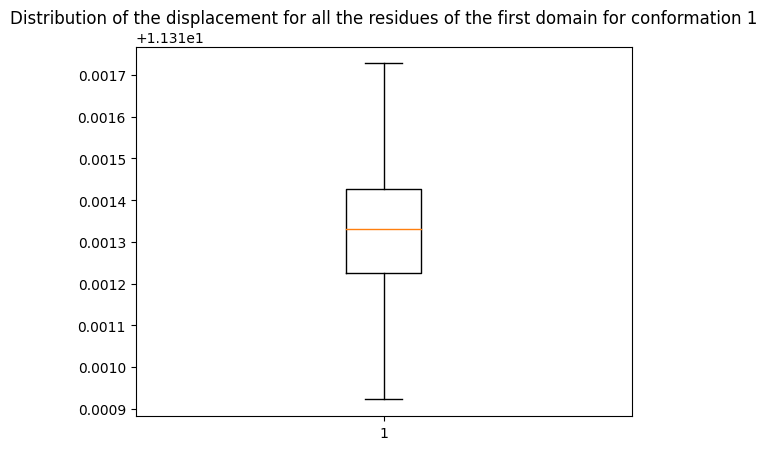

In [693]:
translations_magnitude_training = torch.sqrt(torch.sum(translations_training**2, dim=-1))
plt.boxplot(translations_magnitude_training[:5000, :300].flatten().detach().numpy(), showfliers=False)
plt.title("Distribution of the displacement for all the residues of the first domain for conformation 1")
plt.show()

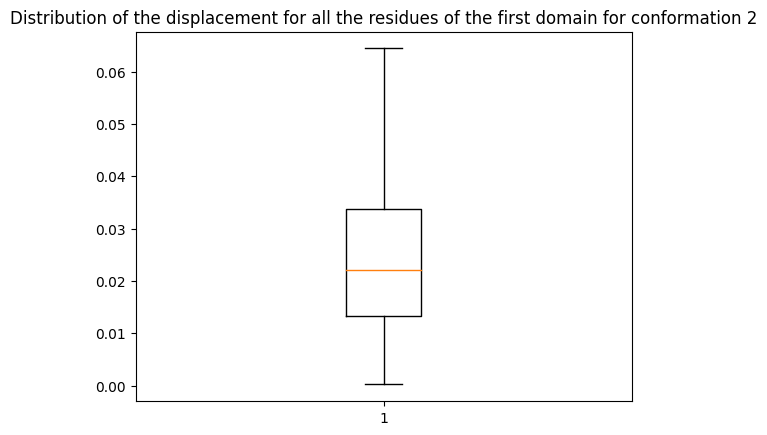

In [695]:
translations_magnitude_training = torch.sqrt(torch.sum(translations_training**2, dim=-1))
plt.boxplot(translations_magnitude_training[5000:, :300].flatten().detach().numpy(), showfliers=False)
plt.title("Distribution of the displacement for all the residues of the first domain for conformation 2")
plt.show()

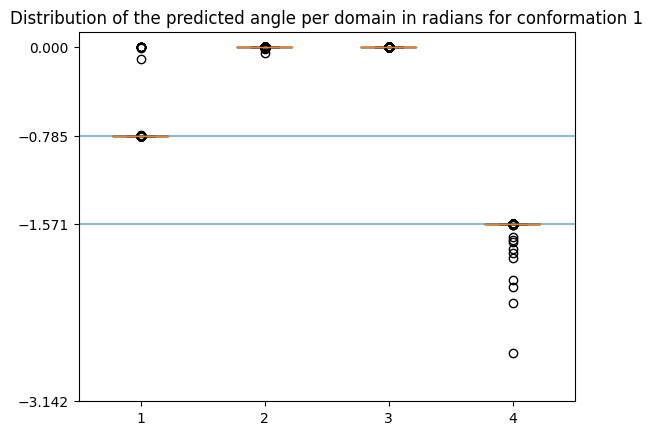

In [731]:
angle_training, axis_training = get_axis_and_angle(axis_angle_per_domain_training)
angle_training *= -1
axis_training *= -1
plt.boxplot(angle_training[:5000, :], showfliers=True)
plt.title("Distribution of the predicted angle per domain in radians for conformation 1")
plt.yticks([0, -np.pi/4, -np.pi/2, -np.pi])
plt.axhline(y=-np.pi/4, alpha = 0.5)
plt.axhline(y=-np.pi/2, alpha = 0.5)
plt.show()

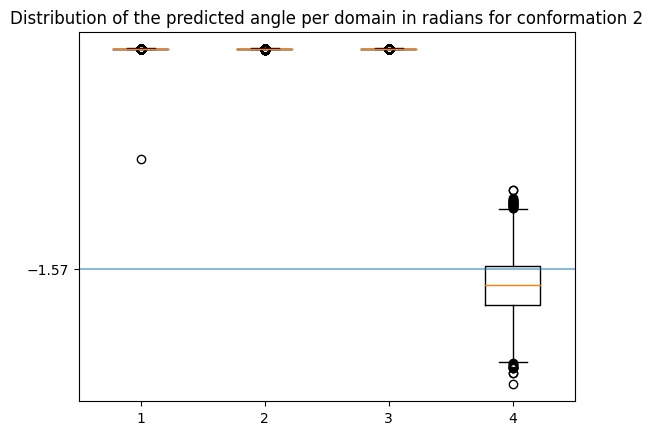

In [746]:
angle_training, axis_training = get_axis_and_angle(axis_angle_per_domain_training)
angle_training *= -1
axis_training *= -1
plt.boxplot(angle_training[5000:, :], showfliers=True)
plt.title("Distribution of the predicted angle per domain in radians for conformation 2")
plt.yticks([-np.pi/2])
plt.axhline(y=-np.pi/2, alpha = 0.5)
plt.show()

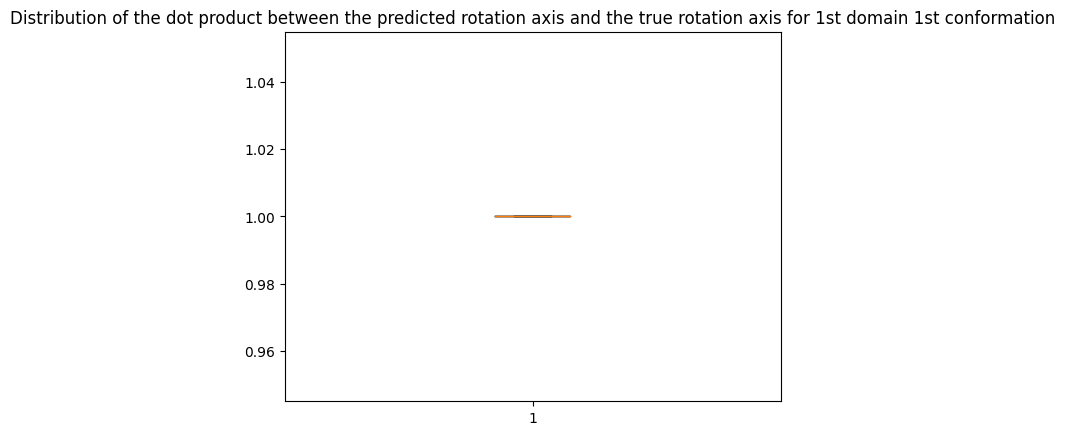

In [721]:
dot_prod = np.matmul(axis_training[:5000, 0, :], np.array([0.0, 0.0, 1.0]))
plt.boxplot(dot_prod, showfliers=False)
plt.title("Distribution of the dot product between the predicted rotation axis and the true rotation axis for 1st domain 1st conformation")
plt.show()

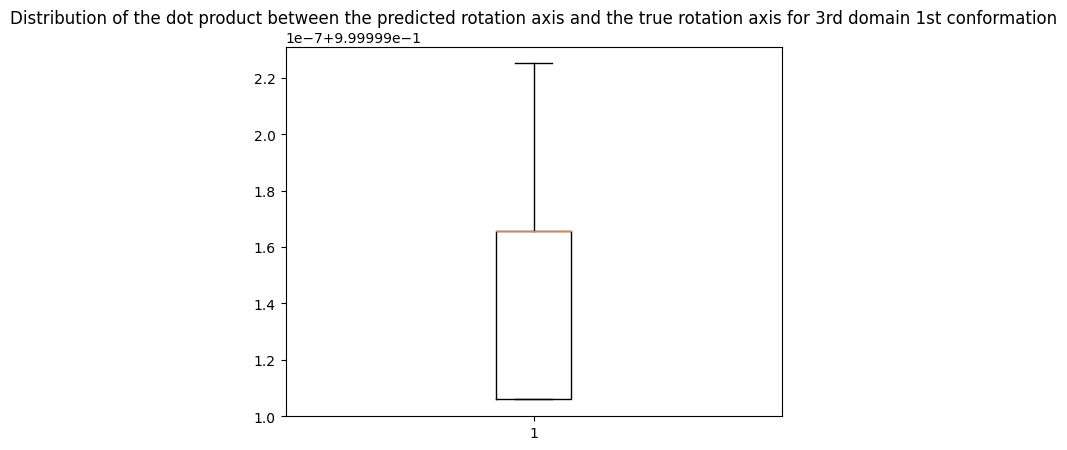

In [776]:
dot_prod = np.matmul(axis_training[:5000, 3, :], np.array([0.0, -1.0, 0.0]))
plt.boxplot(dot_prod, showfliers=False)
plt.title("Distribution of the dot product between the predicted rotation axis and the true rotation axis for 3rd domain 1st conformation")
plt.show()

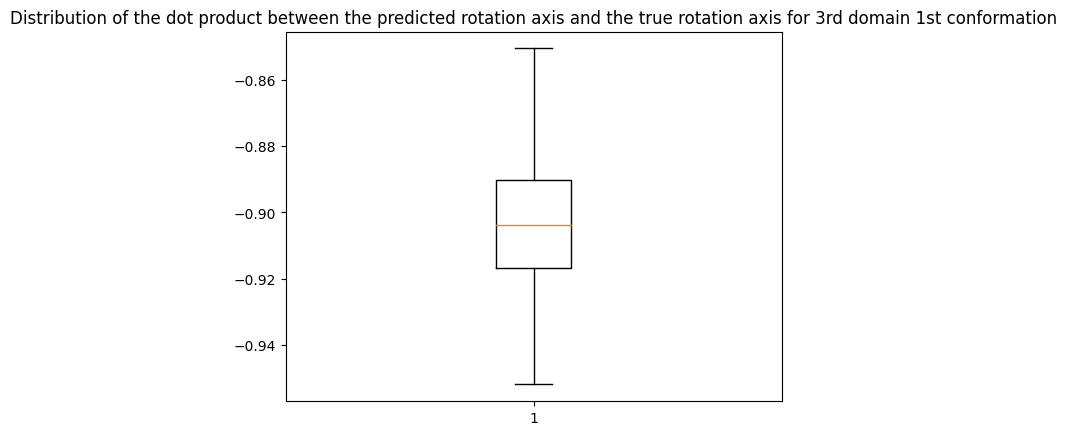

In [747]:
dot_prod = np.matmul(axis_training[5000:, 3, :], np.array([0.0, 1.0, 0.0]))
plt.boxplot(dot_prod, showfliers=False)
plt.title("Distribution of the dot product between the predicted rotation axis and the true rotation axis for 3rd domain 1st conformation")
plt.show()

In [779]:
#pdb_parser = PDBParser()
#io = PDBIO()
#for i in range(5000, 10000):
#    if i%100 == 0:
#        print(i)
        
#    struct = pdb_parser.get_structure("A", "data/vae2Conformations/ranked_0.pdb")
#    protein.main.rotate_residues(struct, rotations_per_residue_np[i], local_frame_in_columns)
#    protein.main.translate_residues(struct, translations_np[i])
#    io.set_structure(struct)
#    io.save("data/vae2Conformations/conformation2/predicted"+str(i)+".pdb", preserve_atom_numbering = True)
    

In [ ]:
#rotations = torch.load("data/vae2Conformations/training_conformation_rotation_matrices.npy", map_location=torch.device('cpu'))
#translations = torch.load("data/vae2Conformations/training_set.npy", map_location=torch.device('cpu'))

In [ ]:
#pdb_parser = PDBParser()
#io = PDBIO()
#struct = pdb_parser.get_structure("A", "data/vae2Conformations/ranked_0.pdb")
#protein.main.rotate_domain_pdb_structure_matrix(struct, 0, 300, rotations[6000, 0, :, :], local_frame_in_columns)
#protein.main.rotate_domain_pdb_structure_matrix(struct, 1353, 1510, rotations[6000, 2, :, :], local_frame_in_columns)
#protein.main.translate_domain_pdb_structure(struct, 0, 300, translations[6000, :3])
#io.set_structure(struct)
#io.save("data/vae2Conformations/conformation2/true_structure.pdb", preserve_atom_numbering = True)

In [ ]:
#import os
#all_rmsd = {}
#all_files = [f for f in os.listdir("data/vae2Conformations/conformation2/") if f !="true_structure.pdb"]
#for i, file in enumerate(all_files):
#    rmsd = protein.main.compute_rmsd_pdb("data/vae2Conformations/conformation2/true_structure.pdb", "data/vae2Conformations/conformation2/"+file)
#    print(i, rmsd)
#    all_rmsd[file] = rmsd

In [ ]:
#sorted_rmsd = sorted(list(all_rmsd.items()), key = lambda x: x[1])

In [780]:
#with open("data/vae2Conformations/conformation2/rmsd.txt", "w") as f:
#    for i, tup in enumerate(sorted_rmsd):
#        print(i)
#        f.write(f"{tup[0]}\t {tup[1]}\n")

### B. Test set

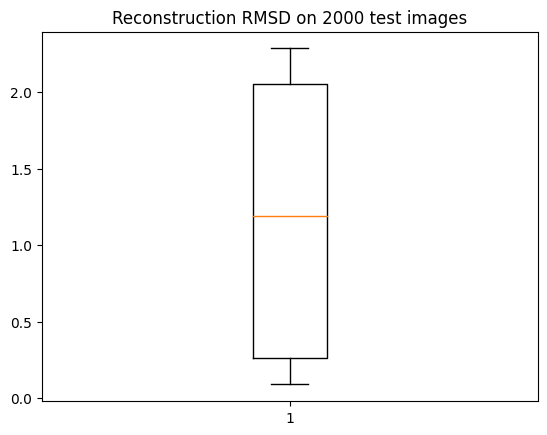

In [782]:
test_rmsd = np.load("data/vae2Conformations/test_run/losses_rmsd.npy")
plt.boxplot(test_rmsd)
plt.title("Reconstruction RMSD on 2000 test images")
plt.show()

In [748]:
latent_distrib_test = np.load("data/vae2Conformations/test_run/latent_distrib.npy")
indexes = np.load("data/vae2Conformations/indexes.npy")
all_latent_distrib_test = np.concatenate(latent_distrib_test, axis= 0)
all_indexes = np.concatenate(indexes, axis= 0)
cols = ["blue" if i < 5000 else "red" for i in all_indexes]

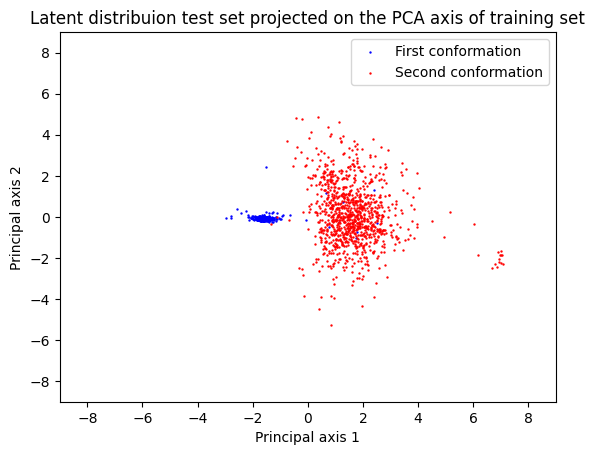

In [752]:
pca_latent_test = pca.transform(all_latent_distrib_test[:, :9])
plt.scatter(pca_latent_test[:1000, 0], pca_latent_test[:1000, 1], s=0.5, color="blue", label="First conformation")
plt.scatter(pca_latent_test[1000:, 0], pca_latent_test[1000:, 1], s=0.5, color="red", label="Second conformation")
plt.xlim([-9, 9])
plt.ylim([-9, 9])
plt.xlabel("Principal axis 1")
plt.ylabel("Principal axis 2")
plt.legend(loc="upper right")
plt.title("Latent distribuion test set projected on the PCA axis of training set")
plt.show()

In [753]:
translations_test, rotations_per_residue_test, axis_angle_per_domain_test = sample_structure(
    torch.tensor(all_latent_distrib_test[:, :9], dtype=torch.float32), model)

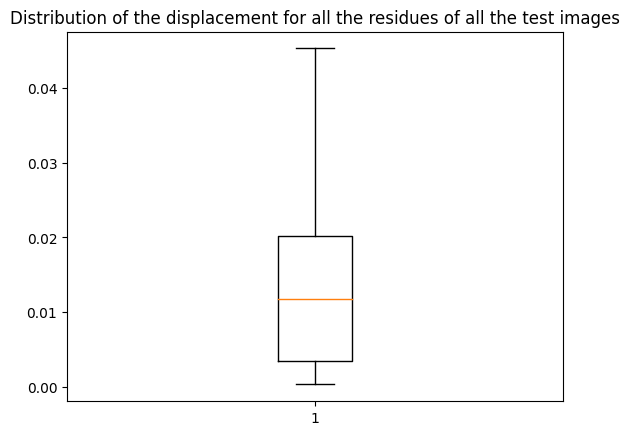

In [754]:
translations_magnitude_test = torch.sqrt(torch.sum(translations_test**2, dim=-1))
plt.boxplot(translations_magnitude_test[:, 300:].flatten().detach().numpy(), showfliers=False)
plt.title("Distribution of the displacement for all the residues of all the test images")
plt.show()

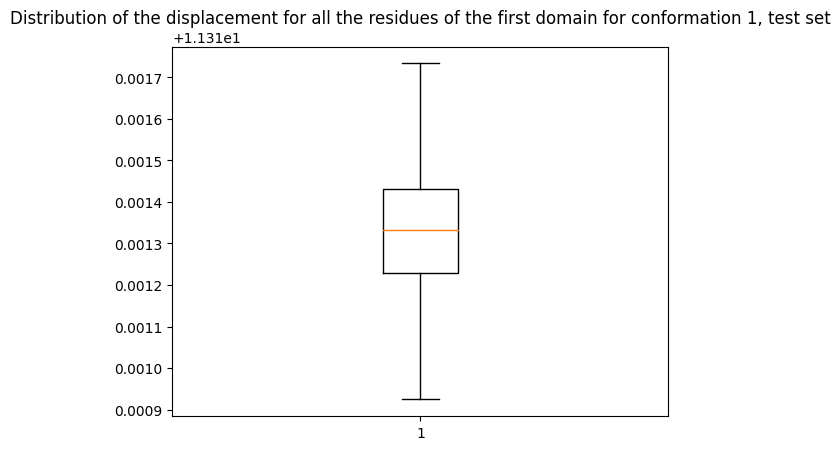

In [755]:
translations_magnitude_test = torch.sqrt(torch.sum(translations_test**2, dim=-1))
plt.boxplot(translations_magnitude_training[:1000, :300].flatten().detach().numpy(), showfliers=False)
plt.title("Distribution of the displacement for all the residues of the first domain for conformation 1, test set")
plt.show()

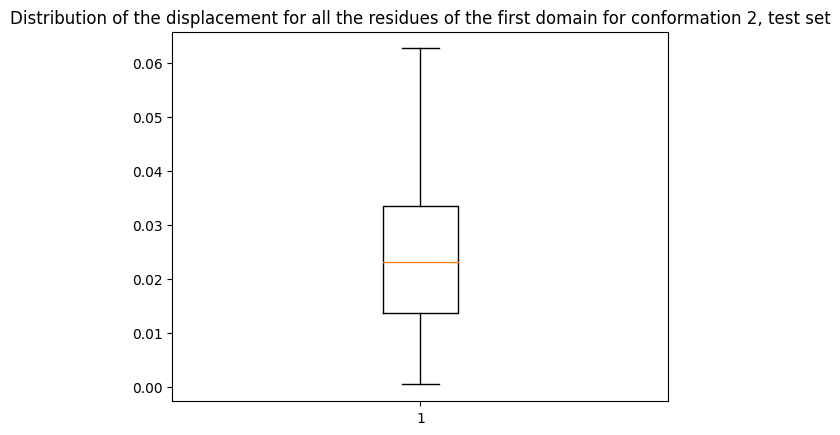

In [759]:
translations_magnitude_test = torch.sqrt(torch.sum(translations_test**2, dim=-1))
plt.boxplot(translations_magnitude_test[1000:, :300].flatten().detach().numpy(), showfliers=False)
plt.title("Distribution of the displacement for all the residues of the first domain for conformation 2, test set")
plt.show()

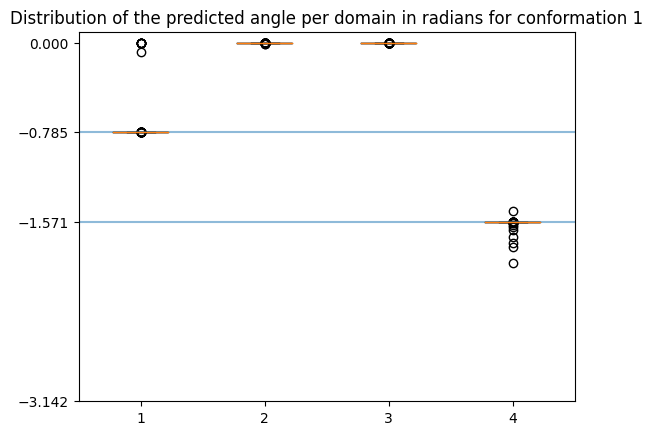

In [761]:
angle_test, axis_test = get_axis_and_angle(axis_angle_per_domain_test)
angle_test *= -1
axis_test *= -1
plt.boxplot(angle_test[:1000, :], showfliers=True)
plt.title("Distribution of the predicted angle per domain in radians for conformation 1")
plt.yticks([0, -np.pi/4, -np.pi/2, -np.pi])
plt.axhline(y=-np.pi/4, alpha = 0.5)
plt.axhline(y=-np.pi/2, alpha = 0.5)
plt.show()

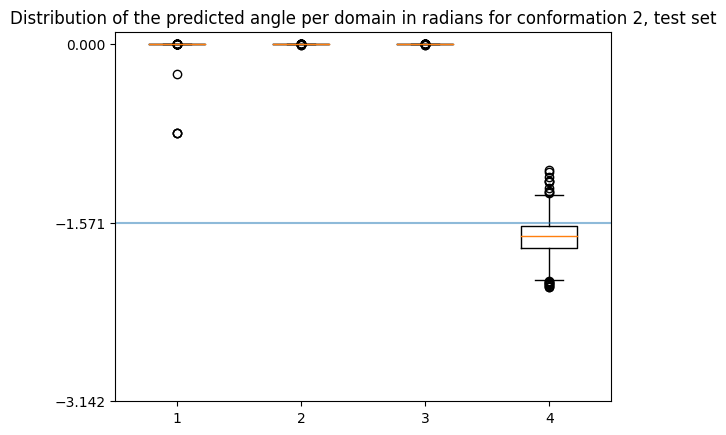

In [764]:
angle_test, axis_test = get_axis_and_angle(axis_angle_per_domain_test)
angle_test *= -1
axis_test *= -1
plt.boxplot(angle_test[1000:, :], showfliers=True)
plt.title("Distribution of the predicted angle per domain in radians for conformation 2, test set")
plt.yticks([0, -np.pi/2, -np.pi])
plt.axhline(y=-np.pi/2, alpha = 0.5)
plt.show()

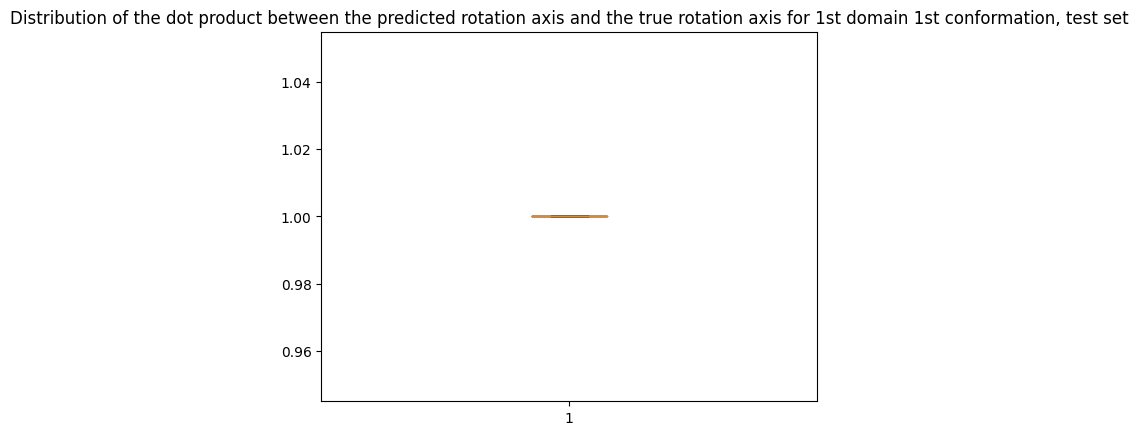

In [767]:
dot_prod = np.matmul(axis_test[:1000, 0, :], np.array([0.0, 0.0, 1.0]))
plt.boxplot(dot_prod, showfliers=False)
plt.title("Distribution of the dot product between the predicted rotation axis and the true rotation axis for 1st domain 1st conformation, test set")
plt.show()

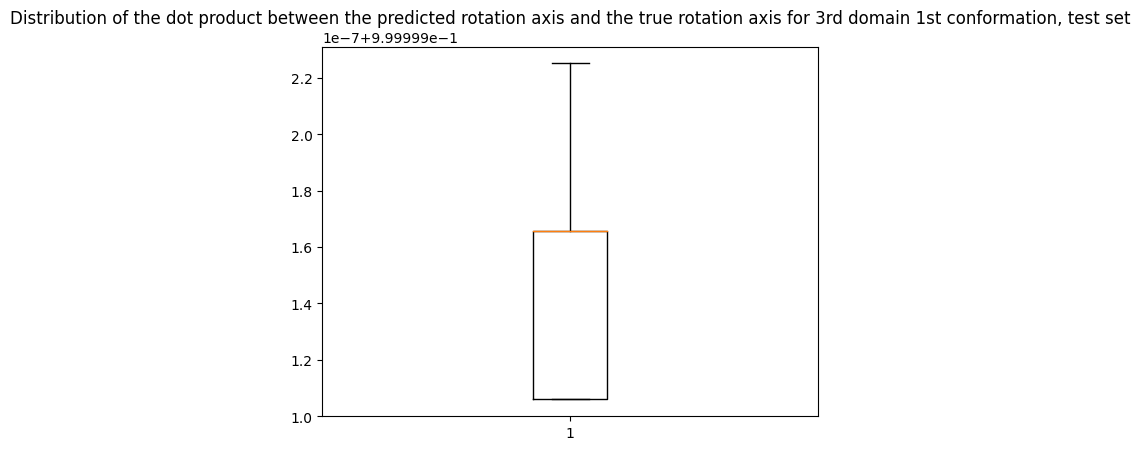

In [774]:
dot_prod = np.matmul(axis_test[:1000, 3, :], np.array([0.0, -1.0, 0.0]))
plt.boxplot(dot_prod, showfliers=False)
plt.title("Distribution of the dot product between the predicted rotation axis and the true rotation axis for 3rd domain 1st conformation, test set")
plt.show()

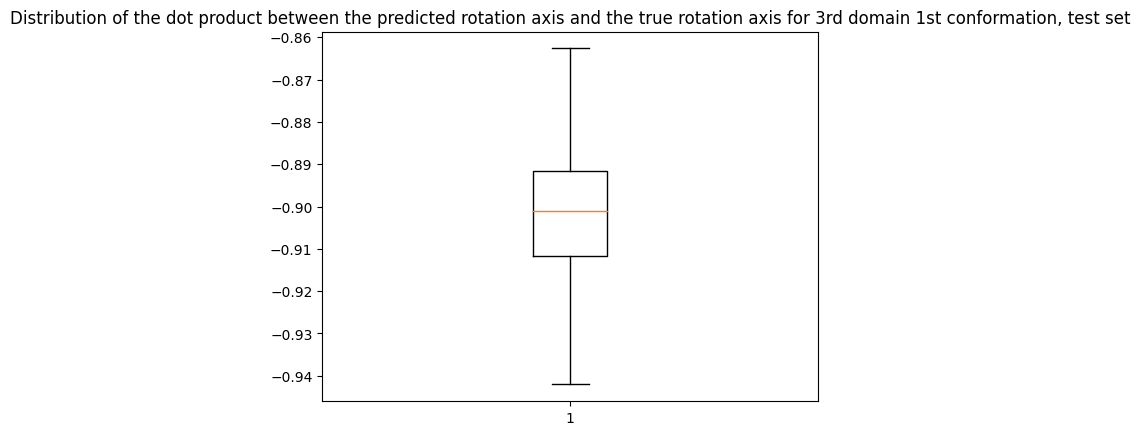

In [778]:
dot_prod = np.matmul(axis_test[1000:, 3, :], np.array([0.0, 1.0, 0.0]))
plt.boxplot(dot_prod, showfliers=False)
plt.title("Distribution of the dot product between the predicted rotation axis and the true rotation axis for 3rd domain 1st conformation, test set")
plt.show()

In [45]:
rmsd = np.load("data/vae2ConformationsDecoupledLatentOld/losses_rmsd.npy")

In [46]:
rmsd

array([27.478807, 27.263916, 28.459076, ..., 10.896091,  9.968733,
       10.258037], dtype=float32)

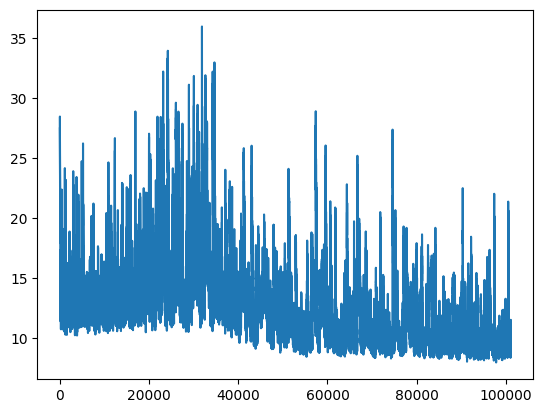

In [47]:
plt.plot(rmsd)

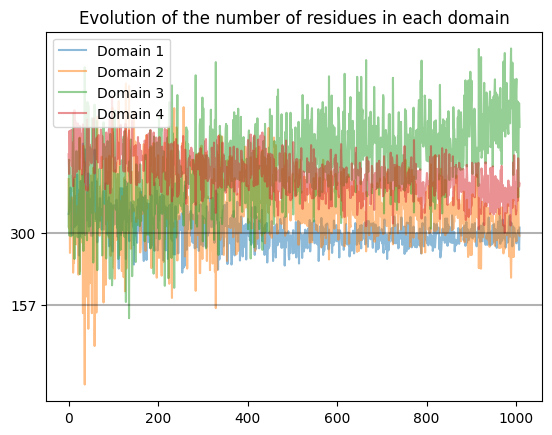

In [48]:
mask_evol = mask_evolution("data/vae2ConformationsDecoupledLatentOld/")
plt.plot(mask_evol[:, 0], label="Domain 1", alpha=0.5)
plt.plot(mask_evol[:, 1], label="Domain 2", alpha=0.5)
plt.plot(mask_evol[:, 2], label="Domain 3", alpha=0.5)
plt.plot(mask_evol[:, 3], label="Domain 4", alpha=0.5)
plt.axhline(y=157, alpha=0.3, color="black")
plt.axhline(y=300, alpha=0.3, color="black")
plt.yticks([157, 300])
plt.legend(loc="upper left")
plt.title("Evolution of the number of residues in each domain")
plt.show()

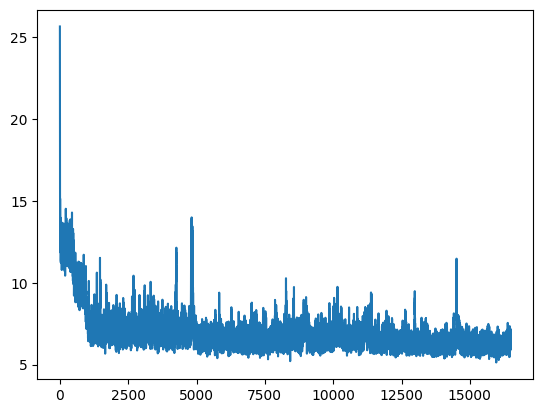

In [54]:
rmsd = np.load("data/vae2ConformationsDecoupledLatent/losses_rmsd.npy")
plt.plot(rmsd)

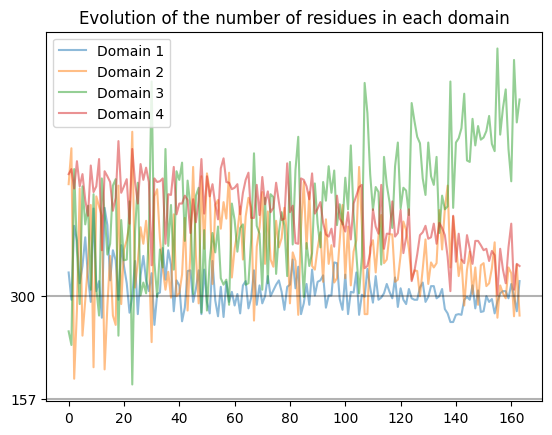

In [55]:
mask_evol = mask_evolution("data/vae2ConformationsDecoupledLatent/")
plt.plot(mask_evol[:, 0], label="Domain 1", alpha=0.5)
plt.plot(mask_evol[:, 1], label="Domain 2", alpha=0.5)
plt.plot(mask_evol[:, 2], label="Domain 3", alpha=0.5)
plt.plot(mask_evol[:, 3], label="Domain 4", alpha=0.5)
plt.axhline(y=157, alpha=0.3, color="black")
plt.axhline(y=300, alpha=0.3, color="black")
plt.yticks([157, 300])
plt.legend(loc="upper left")
plt.title("Evolution of the number of residues in each domain")
plt.show()